In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#cd

In [3]:
#ls

In [4]:
!pip install jiwer # modelin doğruluğunu ,kaybını tespit etmek için.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.5 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer  import wer

In [6]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file('LJSpeech-1.1', data_url, untar = True)

2748572632/2748572632 [==============================] - 235s 0us/step


In [7]:
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

In [8]:
metadata_df = pd.read_csv(metadata_path, sep= "|", header = None, quoting= 3 )
metadata_df.head(16)

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
5,LJ001-0006,"And it is worth mention in passing that, as an...","And it is worth mention in passing that, as an..."
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ..."
7,LJ001-0008,has never been surpassed.,has never been surpassed.
8,LJ001-0009,"Printing, then, for our purpose, may be consid...","Printing, then, for our purpose, may be consid..."
9,LJ001-0010,"Now, as all books not primarily intended as pi...","Now, as all books not primarily intended as pi..."


In [9]:
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac = 1).reset_index(drop = True)
metadata_df.head(10)

,file_name,normalized_transcription
0,LJ046-0096,Nevertheless the procedures and advice should ...
1,LJ016-0003,and that none of its inmates could hope to esc...
2,LJ009-0192,The dissection of executed criminals was aboli...
3,LJ020-0078,Do all this at bedtime. Early in the morning t...
4,LJ038-0262,"Robert A. Frazier, an FBI ballistics identific..."
5,LJ011-0063,Fauntleroy was not entirely dependent upon the...
6,LJ050-0271,The demands on the President in the execution ...
7,LJ031-0207,The Secret Service established a communication...
8,LJ012-0294,without hesitation brought in a verdict of wil...
9,LJ029-0110,The route impressed the agents as a natural an...


In [10]:
#datasetimizin train ve validationa bölünmesi
split = int(len(metadata_df)  * 0.9)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

In [11]:
#alfabe karaketerlerinin tanımlandırılması ve sayısallaşitırılması
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

#keras.layers.StringLookup sınıfı, bir sözlüğü oluşturmak ve bir dizi karakteri sayısal değerlere dönüştürmek için kullanılır.
#vocabulary parametresi, sözlükteki benzersiz karakterlerin listesini içerir. 
#oov_token parametresi, sözlükte bulunmayan karakterler için bir yer tutucu değer belirler.
char_to_num = keras.layers.StringLookup(vocabulary = characters, oov_token="")
 
#Bu nesne, karakter dizisindeki her bir karakterin sayısal değerini içeren bir sözlüğü temsil eder.
num_to_char = keras.layers.StringLookup(vocabulary = char_to_num.get_vocabulary(),
                                        oov_token="", invert = True)

print(f"Vocabulary: {char_to_num.get_vocabulary()}"
      f"(size= {char_to_num.vocabulary_size()})")

Vocabulary: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '](size= 31)


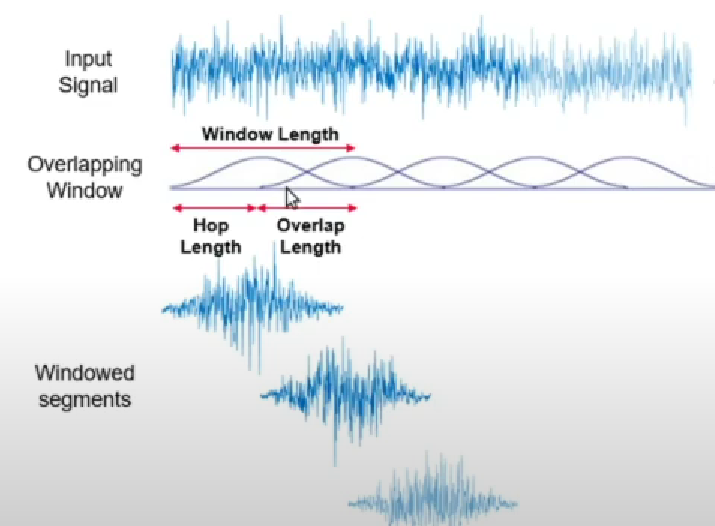

In [12]:
frame_length = 256 #frame_length değişkeni, STFT işlemi sırasında kullanılacak pencere boyutunu belirtir.
frame_step = 160 #frame_step değişkeni, STFT işlemi sırasında kullanılacak pencere kaydırma boyutunu belirtir .
fft_length = 384 #fft_length değişkeni, STFT işlemi sırasında kullanılacak FFT (Fast Fourier Transform) boyutunu belirtir.

def encode_single_sample(wav_file, label):
    file = tf.io.read_file(wavs_path + wav_file + ".wav") # ses dosyasının okunma işlemi

    audio, _ = tf.audio.decode_wav(file)  #Ses dosyası sayısal hale çözümlenir. 
    audio = tf.squeeze(audio, axis=-1) #tekrar eden değerlerin atılması

    audio = tf.cast(audio, tf.float32)

    #Bu fonksiyon, kısa süreli Fourier dönüşümü (STFT) uygulayarak, ses sinyalini frekans-zaman uzayında temsil eden bir spektrogram oluşturur.
    #STFT (Short-Time Fourier Transform), bir ses sinyalinin frekans bileşenlerini zamana göre analiz etmek için kullanılan bir matematiksel işlemdir. 
    #STFT, uzun bir ses sinyalini küçük parçalara bölerek, her bir parçanın spektrogramını hesaplar
    spectrogram = tf.signal.stft( audio, frame_length = frame_length, 
                                 frame_step = frame_step, fft_length = fft_length)
    
    #Normalize işlemleri
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    means = tf.math.reduce_mean(spectrogram, 1, keepdims = True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims = True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    label = tf.strings.lower(label) #Etiketler küçük harfe çevrilir 

    #fonksiyonu ile Unicode kodlama standardına göre ayrıştırılır. Bu işlem, etiketteki her bir karakterin sayısal bir değere dönüştürülmesi için gereklidir.
    label = tf.strings.unicode_split(label, input_encoding = "UTF-8") 

    #7.	Karakterleri sayısal değerlere dönüştürmek için char_to_num fonksiyonu çağrılır. Bu fonksiyon, etiketlerdeki her bir karakteri, karakter kümesindeki sırasına göre bir sayıya dönüştürür
    label = char_to_num(label)

    return spectrogram, label

In [13]:
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"])) )

train_dataset = (train_dataset.map(
    encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).padded_batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list (df_val["normalized_transcription"])) )

validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).padded_batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE) )

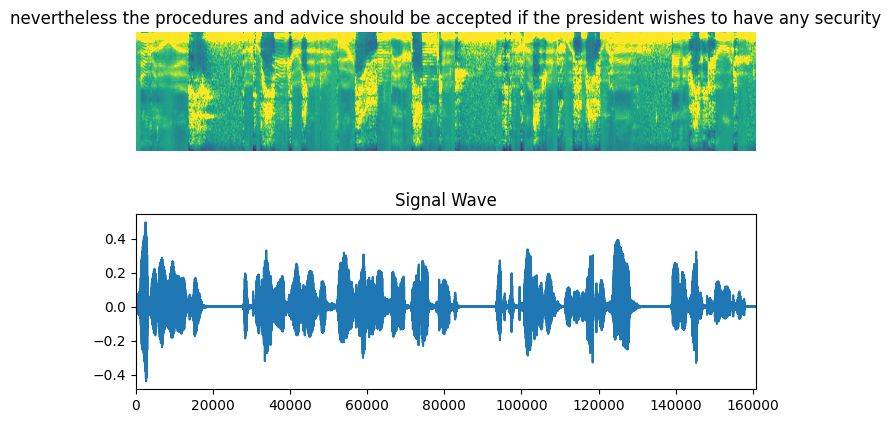

In [14]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):  #yöntemi, eğitim veri kümesinden sadece bir örnek alır.
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)). numpy().decode("utf-8") #burada sayısal etiketler karakterlere dönüştürür.
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis ("off")
    
    # Wav
    # İkinci grafik, ses sinyali dalga formunu gösterir. 
    file = tf.io.read_file(wavs_path + list (df_train["file_name"])[0] + ".wav") 
    audio, _ = tf.audio.decode_wav(file) #bu yöntem, ses dosyasını çözümler ve dalga formu ve örnekleme sıklığı gibi bilgileri içeren bir tensör döndürür.
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim (0, len (audio))
    display.display (display.Audio (np.transpose (audio), rate=16000))# Bu yöntem, ses sinyalini dinlemek için bir ses öğesi oluşturur. Audio() sınıfı, NumPy dizisini ve örnekleme sıklığını alır ve bir ses öğesi oluşturur.
plt.show()

In [15]:
def CTCLoss (y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    #Bu yöntem, CTC kaybını hesaplar. Bu yöntem, y_true, y_pred, input_length ve label_length tensörlerini alır ve CTC kaybını döndürür.
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss #loss değişkeni, CTC kaybını içeren bir tensördür.


In [16]:
def build_model(input_dim, output_dim, rnn_layers = 5, rnn_units = 128):
  
  #	input_dim parametresi, girdi spektrogramının boyutunu belirtir.
  #	output_dim parametresi, modelin çıkış boyutunu belirtir.
  #	rnn_layers parametresi, modeldeki RNN (Recurrent Neural Network) katmanları sayısını belirtir. Varsayılan değeri 5'tir.
  #	rnn_units parametresi, RNN katmanlarındaki birim sayısını belirtir. Varsayılan değeri 128'dir.
  

    input_spectrogram = layers.Input((None, input_dim), name = 'input') 

    x = layers.Reshape((-1, input_dim, 1), name = "expand_dim")(input_spectrogram)

    #1ci convolusyon katmani
    x = layers.Conv2D(filters = 32, kernel_size = [11, 41], strides = [2, 2], 
                      padding ="same", use_bias = False, name = "conv_1" )(x)
    x = layers.BatchNormalization(name = "conv_1_bn")(x)
    x = layers.ReLU(name = "conv_1_relu")(x)
    
    #2ci convolusyon katmani
    x = layers.Conv2D(filters = 32, kernel_size = [11, 21], strides = [1, 2], 
                      padding ="same", use_bias = False, name = "conv_2" )(x)
    x = layers.BatchNormalization(name = "conv_2_bn")(x)          # evrişimli sinir ağı katmanlarındakiağırlıkları normalize eder.
    x = layers.ReLU(name = "conv_2_relu")(x)                      # evrişimli sinir ağı katmanlarındaki aktivasyon fonksiyonunu tanımlar.

    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)        # tensörün şeklini yeniden şekillendirir.

    for i in range(1, rnn_layers + 1):
      #yöntemi, RNN katmanını tanımlar.
        recurrent = layers.GRU(units = rnn_units, activation = "tanh", recurrent_activation= "sigmoid", 
                               use_bias = True, return_sequences = True, reset_after = True, name = f"gru_{i}")
        x = layers.Bidirectional(recurrent, name = f"bidirectional_{i}", merge_mode = "concat" )(x)
        if i<rnn_layers:
            x = layers.Dropout(rate = 0.5)(x)
    #Dense Layer
    x = layers.Dense(units = rnn_units * 2, name = "dense_1")(x)  # modelin yoğun katmanını tanımlar.
    x = layers.ReLU(name = "dense_1_relu")(x)                     # evrişimli sinir ağı katmanlarındaki aktivasyon fonksiyonunu tanımlar.
    x = layers.Dropout(rate = 0.5)(x)

    #classification layer
    output = layers.Dense(units = output_dim + 1, activation = "softmax")(x)
    #model
    model = keras.Model(input_spectrogram, output, name = "DeepSpeech_2") # girdi ve çıktı tensörlerini kullanarak modeli oluşturur.
    #optimizer
    opt = keras.optimizers.Adam(learning_rate = 1e-4)                     # optimize ediciyi tanımlar.
    #compile the model and return
    model.compile(optimizer = opt, loss= CTCLoss)                         # modeli derler ve kayıp fonksiyonunu belirler.
    return model

#get the model
model = build_model(input_dim = fft_length // 2 + 1,
                    output_dim = char_to_num.vocabulary_size(), 
                    rnn_units = 512,)
model.summary(line_length = 110)




Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [17]:
#pred parametresi, modelin tahminlerini içeren bir numpy dizisidir.
def decode_batch_predictions (pred):                  #decode_batch_predictions() fonksiyonu, modelin çıktısını çözümlemek için kullanılır.
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search 
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0] # Iterate over the results and get back the text 
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8") 
        output_text.append(result)
    return output_text

class CallbackEval(keras.callbacks.Callback): 
    def __init__(self, dataset): 
        super().__init__() 
        self.dataset = dataset

    def on_epoch_end (self, epoch: int, logs=None): 
        predictions = [] 
        targets = [] 
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions) 
            predictions.extend(batch_predictions)
            for label in y:
                label = (tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))
                targets.append(label)

        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("_"*100)

In [18]:
epochs = 5

validation_callback = CallbackEval(validation_dataset)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs = epochs,
    callbacks=[validation_callback]
)

Epoch 1/5
1/1 [==============================] - 3s 3s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target : opened it took out and broke into the bullion box removed the gold substituted the shot from a carpet bag
Prediction: 
____________________________________________________________________________________________________
Target : with dallas scheduled as one of the stops
Prediction: 
____________________________________________________________________________________________________
185/185 [==============================] - 1941s 10s/step - loss: 325.9074 - val_loss: 1241.1871
Epoch 2/5
1/1 [==============================] - 1s 632ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
-----------------------------------

In [19]:
!pip install googletrans==4.0.0-rc1

from googletrans import Translator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 9.5 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=94efbe6ec2841cd787d550eb366f29a5887c042c9e754bdf4a0abceb289f0244
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans

In [20]:
predictions = [] 
targets = [] 
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions) 
    predictions.extend(batch_predictions)

    for label in y:
        label = ( tf.strings.reduce_join(num_to_char (label)).numpy().decode("utf-8"))
        targets.append(label)

wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 2):
    print(f"Target : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("_"*100)
        
    translator = Translator()

    #İngilizce bir metni Türkçe'ye çevirme
    text = predictions[i]
    result = translator.translate(text, src='en', dest='tr')

    print(result.text)

1/1 [==============================] - 1s 582ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.7870
----------------------------------------------------------------------------------------------------
Target : on november fourteen lawson and sorrels attended a meeting at love field
Prediction:  on ovember fortn loson an saras tenddid a meainart loffl
____________________________________________________________________________________________________
Kasım ayında Fortnite bir saras eğiliminde bir meainart loffl yaptı
Target : the law made it imperative that every prison should have a prison chapel and that daily and sunday services should be held
Prediction: the lo maed im peritov that ery prison sout ha e prison chal and the daaly and sonday servies shon bhe l
____________________________________________________________________________________________________
Lo Maed Im Peritov Hapishane Sout Hapishane Chal v